<a href="https://colab.research.google.com/github/sayanbanerjee32/coreference-resolution/blob/main/ULMFit_AttentionMask_multiword_LMFineTuned4task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset
https://www.kaggle.com/owen1226/gap-coreference

# Papers and blogs

End2End Coref Resolution By Attention RNN - https://www.kaggle.com/keyit92/end2end-coref-resolution-by-attention-rnn  
coreference-resolution - https://www.kaggle.com/abhishekbhole/coreference-resolution  
SpanBERT - https://arxiv.org/pdf/1907.10529.pdf   
BERT for Coreference Resolution - https://arxiv.org/pdf/1908.09091.pdf  
GITHub for BERT and SpanBERT - https://github.com/mandarjoshi90/coref  
Fast AI solution - https://www.kaggle.com/mamamot/fastai-awd-lstm-solution-0-71-lb/notebook  
With Attention - https://www.kaggle.com/keyit92/end2end-coref-resolution-by-attention-rnn  
Attetion implementation - https://www.kaggle.com/mlwhiz/attention-pytorch-and-keras/notebook

In [40]:
%%capture
!pip install fastai -Uq

In [41]:
# mount gdrive for data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
# file locations
train_file_path = '/content/drive/MyDrive/coref_resolution/data/gap-development.tsv'
val_file_path = '/content/drive/MyDrive/coref_resolution/data/gap-validate.tsv'
test_file_path = '/content/drive/MyDrive/coref_resolution/data/gap-test.tsv'
model_save_path = '/content/drive/MyDrive/coref_resolution/models/'

In [43]:
import pandas as pd
from fastai.text.all import *
from pathlib import Path
from tqdm.notebook import tqdm

In [44]:
train_df = pd.read_csv(train_file_path,sep="\t")
test_df = pd.read_csv(test_file_path,sep="\t")
val_df = pd.read_csv(val_file_path,sep="\t")

In [45]:
train_df["Text"][0], train_df["Text"][1]

("Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.",
 'He grew up in Evanston, Illinois the second oldest of five children including his brothers, Fred and Gordon and sisters, Marge (Peppy) and Marilyn. His high school days were spent at New Trier High School in Winnetka, Illinois. MacKenzie studied with Bernard Leach from 1949 to 1952. His simple, wheel-thrown functional pottery is heavily influenced by the oriental aesthetic of Shoji Hamada and Kanjiro Kawai.')

In [46]:
print(len(train_df), len(val_df), len(test_df))

2000 454 2000


## Fine tune language model

In [47]:
# lets keep val for final testing
df_pretrain = pd.concat([train_df, test_df])
df_pretrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              4000 non-null   object
 1   Text            4000 non-null   object
 2   Pronoun         4000 non-null   object
 3   Pronoun-offset  4000 non-null   int64 
 4   A               4000 non-null   object
 5   A-offset        4000 non-null   int64 
 6   A-coref         4000 non-null   bool  
 7   B               4000 non-null   object
 8   B-offset        4000 non-null   int64 
 9   B-coref         4000 non-null   bool  
 10  URL             4000 non-null   object
dtypes: bool(2), int64(3), object(6)
memory usage: 320.3+ KB


In [48]:
# fine tune language model
data_lm = DataBlock(
            blocks=TextBlock.from_df('Text', is_lm=True),
            get_x=ColReader('text'),
            splitter=RandomSplitter(0.1))

dls_lm = data_lm.dataloaders(df_pretrain) 
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj xxunk went on to hit four home runs in his rookie season while xxunk xxunk . xxmaj however he spent the majority of the season with the triple - a xxmaj rochester xxmaj red xxmaj wings . xxmaj in 2004 , after xxunk impressive minor league numbers , the xxmaj twins dealt veteran first baseman xxmaj doug xxmaj xxunk to the xxmaj boston xxmaj red xxmaj sox and xxmaj xxunk","xxmaj xxunk went on to hit four home runs in his rookie season while xxunk xxunk . xxmaj however he spent the majority of the season with the triple - a xxmaj rochester xxmaj red xxmaj wings . xxmaj in 2004 , after xxunk impressive minor league numbers , the xxmaj twins dealt veteran first baseman xxmaj doug xxmaj xxunk to the xxmaj boston xxmaj red xxmaj sox and xxmaj xxunk became"
1,"was engaged immediately . xxbos xxmaj the next day xxup xxunk xxmaj xxunk , under the command of xxmaj captain xxmaj thomas xxmaj xxunk , encountered xxmaj rachel and captured her , together with the xxunk prize crew of xxmaj americans . xxmaj the xxmaj british took the xxmaj americans on board xxmaj xxunk and put a six - man prize crew on board xxmaj rachel , which they sent her into","engaged immediately . xxbos xxmaj the next day xxup xxunk xxmaj xxunk , under the command of xxmaj captain xxmaj thomas xxmaj xxunk , encountered xxmaj rachel and captured her , together with the xxunk prize crew of xxmaj americans . xxmaj the xxmaj british took the xxmaj americans on board xxmaj xxunk and put a six - man prize crew on board xxmaj rachel , which they sent her into xxmaj"


In [49]:
# create language model learner
learn_lm = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.5, pretrained=True, 
    metrics=[accuracy, Perplexity()])#.to_fp16()

SuggestedLRs(valley=0.009120108559727669)

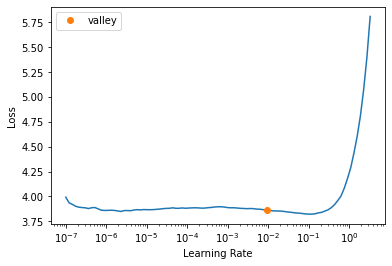

In [50]:
# find optimum learning rate for language model
learn_lm.lr_find()

In [51]:
# one cycle training
learn_lm.fit_one_cycle(1, 0.003)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.728303,3.506631,0.362956,33.335773,00:18


In [52]:
# unfreeze all the layers and one cycle training
learn_lm.unfreeze()
learn_lm.fit_one_cycle(5, 0.003)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.416386,3.310141,0.378602,27.388996,00:20
1,3.245112,3.308045,0.378559,27.331644,00:20
2,2.870928,3.334326,0.381510,28.059473,00:20
3,2.456332,3.417676,0.371853,30.498446,00:20
4,2.177739,3.484099,0.369097,32.593044,00:20


In [53]:
# save language model
learn_lm.save(Path(model_save_path) /'lm_fine_tuned')
learn_lm.save_encoder(Path(model_save_path) /'lm_fine_tuned_encoder')

In [54]:
# load pre-trained language model
# learn_lm_pretrained = load_learner(Path(model_save_path)/'lm_fine_tuned.pth', cpu = False)
# learn_lm.load(Path(model_save_path) /'lm_fine_tuned')

In [55]:
vocab = learn_lm.dls
# vocab.numericalize(tokenizer(train_df["Text"][0]))

## Pre-process data

In [56]:
import torch
from torch.utils.data import Dataset, TensorDataset

In [57]:
spacy_tok = SpacyTokenizer("en")
tokenizer = Tokenizer(spacy_tok)

In [58]:
# train_df["Text"][0], tokenizer(train_df["Text"][0])

In [59]:
import spacy
nlp = spacy.blank("en")

# note that 'xxunk' is not special in this sense
# special_tokens = ['xxbos','xxfld','xxpad', 'xxmaj','xxup','xxrep','xxwrep']

special_tokens = ['xxpad']

def get_token_num_by_offset(s, offset):
  s_pre = s[:offset]
  return len(tokenizer(s_pre))
  # return len([t for t in tokenizer(s_pre) if t not in special_tokens])


def adjust_token_num(processed, token_num):
  """
  As fastai tokenizer introduces additional tokens, we need to adjust for them.
  """
  counter = -1
  do_unrep = None
  for i, token in enumerate(processed):
    if token not in special_tokens:
      counter += 1
    # if do_unrep:
    #   do_unrep = False
    #   if processed[i+1] != ".":
    #     token_num -= (int(token) - 2) # one to account for the num itself
    #   else:  # spacy doesn't split full stops
    #     token_num += 1
    # if token == "xxrep":
    #   do_unrep = True
    if counter == token_num:
      return i
  else: # else for 'for'
    counter2 = -1
    for j, t in enumerate(processed):
      if t not in special_tokens:
        counter2 += 1
      # print(j, counter, t)
    raise Exception(f"{token_num} is out of bounds ({processed})")

In [60]:
import traceback
def dataframe_to_tensors(df, max_len=512):
  # offsets are: pron_tok_offset, a_tok_offset, a_tok_right_offset, b_tok_offset, b_tok_right_offset
  offsets = list()
  labels = np.zeros((len(df),), dtype=np.int64)
  processed = list()
  for i, row in tqdm(df.iterrows()):
    try:
      text = row["Text"]
      a_offset = row["A-offset"]
      a_len = len(nlp(row["A"]))
      
      b_offset = row["B-offset"]
      b_len = len(nlp(row["B"]))

      pron_offset = row["Pronoun-offset"]
      is_a = row["A-coref"]
      is_b = row["B-coref"]
      a_tok_offset = get_token_num_by_offset(text, a_offset)
      b_tok_offset = get_token_num_by_offset(text, b_offset)
      a_right_offset = a_tok_offset + a_len - 1
      b_right_offset = b_tok_offset + b_len - 1
      pron_tok_offset = get_token_num_by_offset(text, pron_offset)
      tokenized = tokenizer(text)[:max_len]
      tokenized = ["xxpad"] * (max_len - len(tokenized))  + tokenized # add padding
      a_tok_offset = adjust_token_num(tokenized, a_tok_offset)
      a_tok_right_offset = adjust_token_num(tokenized, a_right_offset)
      b_tok_offset = adjust_token_num(tokenized, b_tok_offset)
      b_tok_right_offset = adjust_token_num(tokenized, b_right_offset)
      pron_tok_offset = adjust_token_num(tokenized, pron_tok_offset)
      numericalized = vocab.numericalize(tokenized)
      processed.append(torch.tensor(numericalized, dtype=torch.long))
      offsets.append([pron_tok_offset, a_tok_offset, a_tok_right_offset, b_tok_offset, b_tok_right_offset])
      if is_a:
        labels[i] = 0
      elif is_b:
        labels[i] = 1
      else:
        labels[i] = 2
    except Exception as e:
      print(i)
      traceback.print_exc()
      raise
  processed = torch.stack(processed)
  offsets = torch.tensor(offsets, dtype=torch.long)
  labels = torch.from_numpy(labels)
  return processed, offsets, labels

In [61]:
train_ds = TensorDataset(*dataframe_to_tensors(train_df))
valid_ds = TensorDataset(*dataframe_to_tensors(val_df))
test_ds = TensorDataset(*dataframe_to_tensors(test_df))

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [62]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

### Classifier

In [63]:
# learn_lm.freeze()

In [64]:
encoder_hidden_sz = 400
device = torch.device("cuda")

In [65]:
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
        nn.init.kaiming_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim 
        step_dim = self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), 
            self.weight
        ).view(-1, step_dim)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        if mask is not None:
            # mask = index mask
            mask_bool = torch.ones(a.size()).to(device)
            mask_bool = mask_bool.scatter_(1, mask, 0.)
            a = a * mask_bool

        a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)

        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)

In [66]:
def expand_offsets(offset_tensor):
  # Have a list of tensors (which can be of different lengths) 
  data = [torch.tensor(range(x[0],x[1]+1)) for x in offset_tensor]

  # Determine maximum length
  max_offset_len = max([x.squeeze().numel() for x in data])

  # pad all tensors to have same length
  data = [torch.nn.functional.pad(x, pad=(0, max_offset_len - x.numel()),
                                  mode='constant', value=max(x)) for x in data]

  # stack them
  data = torch.stack(data)
  return data

In [67]:
class CorefResolver(nn.Module):
  def __init__(self, encoder, dropout_p=0.3, max_len=512):
    super(CorefResolver, self).__init__()
    self.encoder = encoder
    self.attention_layer = Attention(encoder_hidden_sz, max_len)
    self.dropout = nn.Dropout(dropout_p)
    self.hidden2hidden = nn.Linear(encoder_hidden_sz * 2 + encoder_hidden_sz + 1, 25)
    self.hidden2logits = nn.Linear(50, 3)
    self.relu = nn.ReLU()
    self.activation = nn.LogSoftmax(dim=1)
    self.loss = nn.NLLLoss()
    
  def forward(self, seqs, offsets, labels=None):
    encoded = self.dropout(self.encoder(seqs)) #[0][2])
    # attention mask
    # mask b
    a_offset = expand_offsets(torch.index_select(offsets,1,
                                                 torch.tensor([3, 4]).to(device))).to(device)
    # mask a
    b_offset = expand_offsets(torch.index_select(offsets,1,
                                                 torch.tensor([1, 2]).to(device))).to(device)
    # encoder attention with corresponding mask
    encoded_atten_a = self.attention_layer(encoded,a_offset)
    encoded_atten_b = self.attention_layer(encoded,b_offset)
    a_q = list()
    b_q = list()
    for enc_att_a, enc_att_b, enc, offs in zip(encoded_atten_a, encoded_atten_b , encoded, offsets):
      # extract the hidden states that correspond to A, B and the pronoun, and make pairs of those 
      a_repr = enc[offs[1]:(offs[2]+1)].mean(dim=0).squeeze(0)
      b_repr = enc[offs[3]:(offs[4]+1)].mean(dim=0).squeeze(0)
      a_q.append(torch.cat([enc[offs[0]], a_repr, enc_att_a, torch.dot(enc[offs[0]], a_repr).unsqueeze(0)]))
      b_q.append(torch.cat([enc[offs[0]], b_repr, enc_att_b, torch.dot(enc[offs[0]], b_repr).unsqueeze(0)]))
    a_q = torch.stack(a_q)
    b_q = torch.stack(b_q)
    # apply the same "detector" layer to both batches of pairs
    is_a = self.relu(self.dropout(self.hidden2hidden(a_q)))
    is_b = self.relu(self.dropout(self.hidden2hidden(b_q)))
    # concatenate outputs of the "detector" layer to get the final probability distribution
    is_a_b = torch.cat([is_a, is_b], dim=1)
    is_logits = self.hidden2logits(self.dropout(self.relu(is_a_b)))

    activation = self.activation(is_logits)
    if labels is not None:
      return activation, self.loss(activation, labels)
    else:
      return activation

In [68]:
enc = learn_lm.model[0]

In [69]:
resolver = CorefResolver(enc)

In [70]:
resolver.to(device)

CorefResolver(
  (encoder): AWD_LSTM(
    (encoder): Embedding(10592, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(10592, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (attention_layer): Attention()
  (dropout): Dropout(p=0.3, inplace=False)
  (hidden2hidden): Linear(in_features=1201, out_features=25, bias=True)
  (hidden2logits): Linear(in_features=50, out_features=3, bias=True)
  (relu): ReLU()
  (activation): LogSoftmax(dim=1)
  (loss): NLLLoss()
)

In [71]:
for param in resolver.encoder.parameters():
  param.requires_grad = False

In [72]:
lr = 0.001

loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(resolver.parameters(), lr=lr)

In [73]:
from sklearn.metrics import classification_report

In [74]:
def train_epoch(model, optimizer, train_dl, report_every=10):
  model.train()
  step = 0
  total_loss = 0
  
  for texts, offsets, labels in train_dl:
    texts, offsets, labels = texts.to(device), offsets.to(device), labels.to(device)
    step += 1
    optimizer.zero_grad()
    _, loss = model(texts, offsets, labels)
    total_loss += loss.item()
    
    loss.backward()
    optimizer.step()
    
    if step % report_every == 0:
      print(f"Step {step}, loss: {total_loss/report_every}")
      total_loss = 0
      
def evaluate(model, optimizer, valid_dl, probas=False):
  probas = list()
  model.eval()
  predictions = list()
  total_loss = 0
  all_labels = list()
  with torch.no_grad():
    for texts, offsets, labels in valid_dl:
      texts, offsets, labels = texts.cuda(), offsets.cuda(), labels.cuda()
      preds, loss = model(texts, offsets, labels)
      total_loss += loss.item()
      probas.append(preds.cpu().detach().numpy())
      predictions.extend([i.item() for i in preds.max(1)[1]])
    
    
  print(f"Validation loss: {total_loss/len(valid_dl)}")
  print()
  print(classification_report(valid_dl.dataset.tensors[2].numpy(), predictions))
  if probas:
    return total_loss, np.vstack(probas)
  return total_loss, predictions

In [75]:
total_epoch = 0
best_loss = 1e6

for i in range(10):
  print("Epoch", i + 1)
  total_epoch += 1
  train_epoch(resolver, optimizer, train_dl) 
  loss, labels = evaluate(resolver, optimizer, test_dl)
  if loss < best_loss:
    best_loss = loss
    print(f"Loss improved, saving {total_epoch}")
    torch.save(resolver.state_dict(), Path(model_save_path)/"model_best.pt")

Epoch 1
Step 10, loss: 0.9815385222434998
Step 20, loss: 0.966545832157135
Step 30, loss: 0.9133882164955139
Validation loss: 0.8910105266268291

              precision    recall  f1-score   support

           0       0.70      0.55      0.61       918
           1       0.55      0.82      0.66       855
           2       0.00      0.00      0.00       227

    accuracy                           0.60      2000
   macro avg       0.42      0.46      0.42      2000
weighted avg       0.55      0.60      0.56      2000

Loss improved, saving 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2
Step 10, loss: 0.9029198408126831
Step 20, loss: 0.8852515399456025
Step 30, loss: 0.8555509507656097
Validation loss: 0.8333801702847556

              precision    recall  f1-score   support

           0       0.64      0.73      0.68       918
           1       0.63      0.70      0.66       855
           2       0.00      0.00      0.00       227

    accuracy                           0.63      2000
   macro avg       0.42      0.48      0.45      2000
weighted avg       0.56      0.63      0.60      2000

Loss improved, saving 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3
Step 10, loss: 0.8242246925830841
Step 20, loss: 0.8176587700843811
Step 30, loss: 0.8431166291236878
Validation loss: 0.7863915657240247

              precision    recall  f1-score   support

           0       0.69      0.68      0.69       918
           1       0.62      0.79      0.69       855
           2       0.00      0.00      0.00       227

    accuracy                           0.65      2000
   macro avg       0.44      0.49      0.46      2000
weighted avg       0.58      0.65      0.61      2000

Loss improved, saving 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4
Step 10, loss: 0.796319967508316
Step 20, loss: 0.8187029242515564
Step 30, loss: 0.7863480687141419
Validation loss: 0.7672623045860775

              precision    recall  f1-score   support

           0       0.71      0.70      0.70       918
           1       0.63      0.80      0.71       855
           2       0.00      0.00      0.00       227

    accuracy                           0.66      2000
   macro avg       0.45      0.50      0.47      2000
weighted avg       0.59      0.66      0.62      2000

Loss improved, saving 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5
Step 10, loss: 0.774991226196289
Step 20, loss: 0.7698043584823608
Step 30, loss: 0.780712115764618
Validation loss: 0.7550155350140163

              precision    recall  f1-score   support

           0       0.65      0.78      0.71       918
           1       0.68      0.71      0.69       855
           2       0.00      0.00      0.00       227

    accuracy                           0.66      2000
   macro avg       0.44      0.50      0.47      2000
weighted avg       0.59      0.66      0.62      2000

Loss improved, saving 5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6
Step 10, loss: 0.7512492775917053
Step 20, loss: 0.7860443115234375
Step 30, loss: 0.7733311235904694
Validation loss: 0.7369803038854448

              precision    recall  f1-score   support

           0       0.68      0.76      0.72       918
           1       0.65      0.75      0.70       855
           2       0.00      0.00      0.00       227

    accuracy                           0.67      2000
   macro avg       0.44      0.50      0.47      2000
weighted avg       0.59      0.67      0.63      2000

Loss improved, saving 6


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7
Step 10, loss: 0.7697042047977447
Step 20, loss: 0.7318897128105164
Step 30, loss: 0.7416886866092682
Validation loss: 0.7394653454659477

              precision    recall  f1-score   support

           0       0.74      0.69      0.71       918
           1       0.62      0.83      0.71       855
           2       0.00      0.00      0.00       227

    accuracy                           0.67      2000
   macro avg       0.45      0.51      0.47      2000
weighted avg       0.60      0.67      0.63      2000

Epoch 8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Step 10, loss: 0.7688052356243134
Step 20, loss: 0.6950946569442749
Step 30, loss: 0.762873113155365
Validation loss: 0.7383951242007907

              precision    recall  f1-score   support

           0       0.72      0.70      0.71       918
           1       0.63      0.82      0.71       855
           2       0.00      0.00      0.00       227

    accuracy                           0.67      2000
   macro avg       0.45      0.51      0.47      2000
weighted avg       0.60      0.67      0.63      2000

Epoch 9


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Step 10, loss: 0.7166568756103515
Step 20, loss: 0.7207327067852021
Step 30, loss: 0.7034133732318878
Validation loss: 0.7308664998364827

              precision    recall  f1-score   support

           0       0.74      0.66      0.70       918
           1       0.61      0.84      0.71       855
           2       0.33      0.00      0.01       227

    accuracy                           0.66      2000
   macro avg       0.56      0.50      0.47      2000
weighted avg       0.64      0.66      0.62      2000

Loss improved, saving 9
Epoch 10
Step 10, loss: 0.703052020072937
Step 20, loss: 0.711202883720398
Step 30, loss: 0.7188992977142334
Validation loss: 0.7344149095671517

              precision    recall  f1-score   support

           0       0.75      0.68      0.71       918
           1       0.62      0.85      0.72       855
           2       0.33      0.00      0.01       227

    accuracy                           0.68      2000
   macro avg       0.57      0.51     

## Test

In [76]:
loss, res = evaluate(resolver, optimizer, valid_dl, True)
res_s = np.exp(res)  # don't forget that we have log-softmax outputs:
test_res = pd.DataFrame(res_s, index=val_df["ID"], columns=["A-prob", "B-prob", "NEITHER-prob"])

Validation loss: 0.8058300137519836

              precision    recall  f1-score   support

           0       0.70      0.60      0.65       187
           1       0.57      0.82      0.68       205
           2       0.00      0.00      0.00        62

    accuracy                           0.62       454
   macro avg       0.42      0.47      0.44       454
weighted avg       0.55      0.62      0.57       454



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
val_df.merge(test_res, on = 'ID').loc[:,['ID','Text','Pronoun','A','B','A-coref','B-coref','A-prob','B-prob','NEITHER-prob']].head(10)

,ID,Text,Pronoun,A,B,A-coref,B-coref,A-prob,B-prob,NEITHER-prob
0,validation-1,"He admitted making four trips to China and playing golf there. He also admitted that ZTE officials, whom he says are his golf buddies, hosted and paid for the trips. Jose de Venecia III, son of House Speaker Jose de Venecia Jr, alleged that Abalos offered him US$10 million to withdraw his proposal on the NBN project.",him,Jose de Venecia Jr,Abalos,False,False,0.149981,0.785762,0.064257
1,validation-2,"Kathleen Nott was born in Camberwell, London. Her father, Philip, was a lithographic printer, and her mother, Ellen, ran a boarding house in Brixton; Kathleen was their third daughter. She was educated at Mary Datchelor Girls' School (now closed), London, before attending King's College, London.",She,Ellen,Kathleen,False,True,0.396671,0.525052,0.078277
2,validation-3,"When she returns to her hotel room, a Liberian man (Tony Todd) forces her to smuggle $20 million worth of conflict diamonds to New York, or else fellow fight attendant and friend Angela will die. She is caught before she can board the flight, and the team now have nine hours until the plane lands, and save Angela. After the confiscated diamonds are stolen by the brother of Kaleo (Jason Scott Lee), whom Danny put away for murdering his partner last year, Five-0 and Chief Fryer team up and enlist the help of August March (Ed Asner), who served a 30-year sentence for smuggling diamonds.",his,Jason Scott Lee,Danny,False,True,0.097446,0.876197,0.026356
3,validation-4,"On 19 March 2007, during a campaign appearance for the New South Wales State Election, the then opposition leader Peter Debnam was confronted by Reucassel wearing nothing but Speedos and a baseball cap, making fun of Debnam's campaign appearances in the swimwear. When TV cameras remained focused on Reucassel rather than Mr Debnam, he said, ``Sorry, I'm not Peter Debnam, he's over there.",he,Reucassel,Debnam,True,False,0.450960,0.491769,0.057271
4,validation-5,"By this time, Karen Blixen had separated from her husband, and after their divorce in 1925, Finch Hatton moved into her house and began leading safaris for wealthy sportsmen. Among his clients were Marshall Field Jr and Edward, Prince of Wales. According to the author Mary Lovell, in 1930 Finch Hatton began a love affair with Beryl Markham, who was working as a race-horse trainer in Nairobi and the surrounding area. Later, she would become known as a pioneer flyer herself (Markham attributed her interest in flying to her association with Tom Campbell Black).",she,Finch Hatton,Beryl Markham,False,True,0.633056,0.235179,0.131765
5,validation-6,"No amount of logic can shatter a faith consciously based on a lie.'' According to The Skeptic's Dictionary, an example of this syndrome is evidenced by an event in 1988 when stage magician James Randi, at the request of an Australian news program, coached stage performer Jos* Alvarez to pretend he was channelling a two-thousand-year-old spirit named ``Carlos''.",he,James Randi,Jos* Alvarez,False,True,0.223729,0.566136,0.210134
6,validation-7,Lieutenant General Weber Pasha wanted Faik Pasha to command the ``Right Wing''. But Liman von Sanders disliked him and he had a quarrel with Faik Pasha for about a tactics. Weber Pasha insisted on his decision. At last unwillingly von Sanders appointed Faik Pasha to the command of Right Wing. He fought the Battle of Gully Ravine (28 June -- 3 July 1915) that was a very bloody battle that caused Ottoman Army many casualties.,He,von Sanders,Faik Pasha,False,True,0.555791,0.273344,0.170865
7,validation-8,"He went on to enter mainstream journalism as a reporter and feature writer with the Belfast Sunday News, during the height of the Troubles in Northern Ireland. He was later promoted to Chief Sub- Editor of that newspaper, where he also wrote a weekly column. In 1977 Colin entered into correspondence with a singer and guitar player called Jake Burns, who was trying to promote his band Stiff Little Fi